Davies-Bouldin Index: 1.2912016075367632
Clustered Data (Sample):
  CustomerID  TotalValue  Quantity  Region_Asia  Region_Europe  \
0      C0001   -0.061701 -0.122033        False          False   
1      C0002   -0.877744 -0.448000         True          False   
2      C0003   -0.405857  0.203934        False          False   
3      C0004    1.032547  1.670787        False          False   
4      C0005   -0.783929 -0.936951         True          False   

   Region_North America  Region_South America  Cluster  
0                 False                  True        2  
1                 False                 False        1  
2                 False                  True        2  
3                 False                  True        0  
4                 False                 False        1  


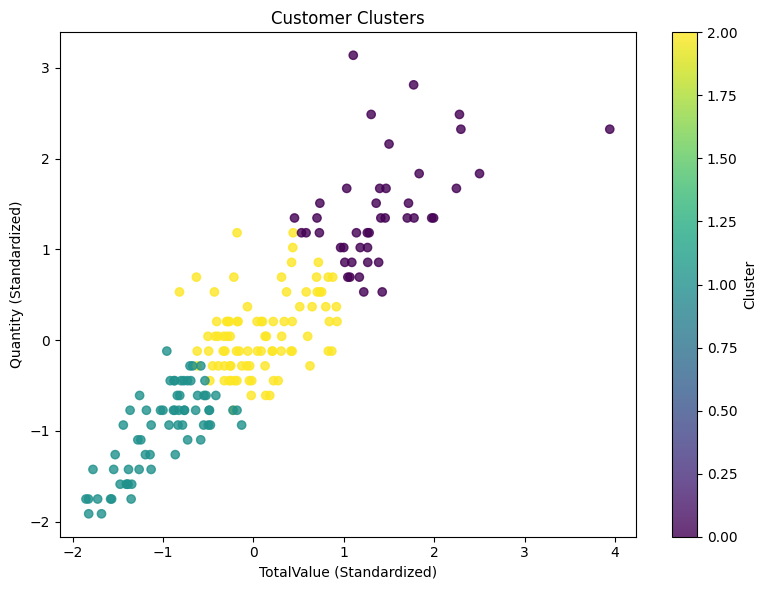

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Step 2: Preprocess customer data
def preprocess_customer_data():
    # Convert date columns to datetime format
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

    # Aggregate transaction data
    customer_spending = transactions_df.groupby('CustomerID').agg({
        'TotalValue': 'sum',
        'Quantity': 'sum'
    }).reset_index()

    # Merge with customer profile information
    customer_data = customer_spending.merge(customers_df[['CustomerID', 'Region']], on='CustomerID')

    # One-hot encode the 'Region' column
    customer_data = pd.get_dummies(customer_data, columns=['Region'])

    # Standardize numerical features
    scaler = StandardScaler()
    customer_data_scaled = customer_data.copy()
    customer_data_scaled[['TotalValue', 'Quantity']] = scaler.fit_transform(customer_data_scaled[['TotalValue', 'Quantity']])

    return customer_data, customer_data_scaled

# Step 3: Perform clustering
def perform_clustering(customer_data_scaled, n_clusters=3):
    # Initialize and fit KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_data_scaled.drop('CustomerID', axis=1))

    # Assign cluster labels to each customer
    customer_data_scaled['Cluster'] = kmeans.labels_

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_data_scaled.drop(['CustomerID', 'Cluster'], axis=1), kmeans.labels_)
    print(f"Davies-Bouldin Index: {db_index}")

    return customer_data_scaled, db_index

# Step 4: Visualize clusters
def visualize_clusters(clustered_data):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        clustered_data['TotalValue'],
        clustered_data['Quantity'],
        c=clustered_data['Cluster'],
        cmap='viridis',
        alpha=0.8
    )
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('TotalValue (Standardized)')
    plt.ylabel('Quantity (Standardized)')
    plt.title('Customer Clusters')
    plt.tight_layout()
    plt.savefig('FirstName_LastName_ClusteringPlot.png')
    plt.show()

if __name__ == "__main__":
    # Preprocess data
    customer_data, customer_data_scaled = preprocess_customer_data()

    # Perform clustering with 3 clusters
    clustered_data, db_index = perform_clustering(customer_data_scaled, n_clusters=3)

    # Save the clustered data
    clustered_data.to_csv('FirstName_LastName_ClusteredData.csv', index=False)

    # Display the first few rows of the clustered dataset
    print("Clustered Data (Sample):")
    print(clustered_data.head())

    # Visualize the clusters
    visualize_clusters(clustered_data)
